In [14]:
import pandas as pd
import numpy as np
import config
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from models import data_preparation
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import torch
from transformers import RobertaForSequenceClassification, BertForSequenceClassification
from transformers import RobertaTokenizer, BertTokenizer
from models.training_pytorch import objective, train_model_with_hyperparams
from models.training_HF import objective_HF
from models.model_config import model_configs
import optuna
import wandb
import argparse
from dotenv import load_dotenv
import os

In [2]:
data_path = config.DATA_DIR 
TWEETS_DATA = pd.read_csv(data_path / "Corona_NLP_train.csv",encoding='ISO-8859-1') 
TEST_DATA = pd.read_csv(data_path / "Corona_NLP_test.csv",encoding='ISO-8859-1')
CSV_PATH = config.DATA_DIR/"processed"


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# EDA 
We start exploring the data

In [ ]:
pd.set_option('display.max_colwidth', None)
print(TWEETS_DATA.head())

1. There are several id columns: Username and ScreenName
2. The date, location of the tweet are categorical
3. sentiment is categorical ordinal    
    
  **let's try to plot and understand the data better**

In [ ]:
print(f"The number of unique ScreenNames: {np.unique(len(TWEETS_DATA['ScreenName']))}")
print(f"The number of unique UserNames: {np.unique(len(TWEETS_DATA['UserName']))}")
print("The length of the data: ", len(TWEETS_DATA))

First of all let's plot the Sentiment

In [ ]:
custom_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
plt.figure(figsize=(8, 4))
sns.countplot(data=TWEETS_DATA, x='Sentiment', order=custom_order, palette='deep')

In [ ]:
print(TWEETS_DATA["TweetAt"].value_counts())

We Can see that the data was taken in march and april,  when covid was at its initial peak, 
let's see if the month can tell us something.  
Maybe one month was more negative than the other

In [ ]:
TWEETS_DATA["month"] = pd.to_datetime(TWEETS_DATA["TweetAt"]).dt.month
print(TWEETS_DATA["month"].value_counts())
## plot sentiment by month
plt.figure(figsize=(8,4))
sns.countplot(data=TWEETS_DATA, x='month', hue='Sentiment', hue_order=custom_order)
plt.title('Sentiment Distribution by Month')

It looks like it distributes the same, counting that march had twice has much tweets

In [ ]:
print(TWEETS_DATA["Location"].value_counts())

It seems that are too many different locations to try to put them together, we will look into it later $$$**##

**Now let's plot the tweets data, let's see what's poping as obvious**

In [ ]:
TWEETS_DATA['text_len'] = TWEETS_DATA['OriginalTweet'].str.len()
sns.histplot(TWEETS_DATA['text_len'], bins=30)

In [ ]:

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Compute number of tokens per tweet
TWEETS_DATA['num_bert_tokens'] = TWEETS_DATA['OriginalTweet'].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot histogram
sns.histplot(TWEETS_DATA['num_bert_tokens'], bins=30)
plt.xlabel("Number of BERT Tokens per Tweet")
plt.ylabel("Count")
plt.title("Distribution of BERT Token Counts in Tweets")
plt.show()


We know the tweeter (former X) had a 280 charecters limit, over it are paid users.  
let's see if it can gain us some knowledge

In [ ]:
TWEETS_DATA["paid_user"] = TWEETS_DATA["OriginalTweet"].apply(lambda x: "paid" if len(x) > 280 else "free")
sns.countplot(data=TWEETS_DATA, x='paid_user', hue='Sentiment', hue_order=custom_order)
plt.xlabel("Is_user paying?")
paid_users = TWEETS_DATA[TWEETS_DATA['paid_user'] == 'paid']
free_users = TWEETS_DATA[TWEETS_DATA['paid_user'] == 'free']

positive = paid_users[paid_users['Sentiment'].isin(['Positive','Extremley Positive'])]['OriginalTweet'].tolist()
negative = paid_users[paid_users['Sentiment'].isin(['Negative','Extremley Negative'])]['OriginalTweet'].tolist()
print(f"Ratio of positive to negative tweets in paid users: {len(positive) / len(negative)}")

positive = free_users[free_users['Sentiment'].isin(['Positive','Extremley Positive'])]['OriginalTweet'].tolist()
negative = free_users[free_users['Sentiment'].isin(['Negative','Extremley Negative'])]['OriginalTweet'].tolist()
print(f"The ratio of positive to negative tweets in free users: {len(positive) / len(negative)}")


The ratios of negative vs positive are relatively the same for paid and free users, so status isn't a good indicator of sentiment.

## Wordclouds
Wordclouds are a great way to visualize the most common words in the tweets.

In [ ]:
text = " ".join(TWEETS_DATA['OriginalTweet'])
WordCloud(width=800, height=400).generate(text).to_image()

https, amp, t, u, Â, itÂ, donÂ, IÂ  Are HTML tokens that we need to take out of the dataset! 

In [ ]:
#INSTEAD OF THIS i SUGGEST DOING THIS (because currently some symbols like \r\r\n\r\r\n are still present):


def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\bamp\b', '', text)                 # Remove "amp"
    text = re.sub(r'\r|\n', ' ', text)                  # Replace \r and \n with space
    text = re.sub(r'\s+', ' ', text).strip()                    # Remove mentions
    return text

#apply:
TWEETS_DATA["tweets"] = TWEETS_DATA["OriginalTweet"].apply(clean_tweet)
TEST_DATA["tweets"] = TEST_DATA["OriginalTweet"].apply(clean_tweet)

In [ ]:
text = " ".join(TWEETS_DATA['tweets'])
WordCloud(width=800, height=400).generate(text).to_image()

In order to take care of weird signs like: 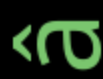  
We tried different encodings (latin and ISO-8859-1)  
We going to take it out manually

In [ ]:
TWEETS_DATA["tweets"] = TWEETS_DATA["tweets"].apply(
    lambda x: x.encode('ascii', errors='ignore').decode()
)

TEST_DATA["tweets"] = TEST_DATA["tweets"].apply(
    lambda x: x.encode('ascii', errors='ignore').decode()
)
text = " ".join(TWEETS_DATA['tweets'])
WordCloud(width=800, height=400).generate(text).to_image()

Now we will explore more wordclouds - per sentiment

In [ ]:
sentiments = custom_order
num_clouds = len(sentiments)

fig, axes = plt.subplots(5, 1, figsize=(5, 20))


# If only one sentiment, axes isn't a list — make it one
if num_clouds == 1:
    axes = [axes]

# Loop through each sentiment and create a word cloud
for ax, sentiment in zip(axes, sentiments):
    subset = TWEETS_DATA[TWEETS_DATA['Sentiment'] == sentiment]
    text = " ".join(subset['tweets'])
    
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(sentiment)
    ax.axis('off')

plt.tight_layout()
plt.show()


Looks like all wordclouds contain similar words, perhaps dipper analysis should be done while extracting covid related key words, to explore better sentiment related words (becuase obsviously positive and negative tweets discussed covid)

**As we all know X (former tweeter) has # and @ in the tweets, let's try to gain some insight from it**

In [ ]:

# Extract @ and #
TWEETS_DATA['hashtags'] = TWEETS_DATA['OriginalTweet'].str.findall(r'#\w+')
TWEETS_DATA['ats'] = TWEETS_DATA['OriginalTweet'].str.findall(r'@\w+')

# Explode and clean
hashtags_df = TWEETS_DATA.explode('hashtags')
ats_df = TWEETS_DATA.explode('ats')

hashtags_df = hashtags_df[hashtags_df['hashtags'].notna()]
ats_df = ats_df[ats_df['ats'].notna()]

# Top N
top_n = 15
top_hashtags = hashtags_df['hashtags'].value_counts().nlargest(top_n).index
top_ats = ats_df['ats'].value_counts().nlargest(top_n).index

# Filtered
filtered_hashtags = hashtags_df[hashtags_df['hashtags'].isin(top_hashtags)]
filtered_ats = ats_df[ats_df['ats'].isin(top_ats)]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

sns.countplot(data=filtered_hashtags, x='hashtags', order=top_hashtags, palette='viridis', ax=axes[0])
axes[0].set_title(f"Top {top_n} Hashtags")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=filtered_ats, x='ats', order=top_ats, palette='coolwarm', ax=axes[1])
axes[1].set_title(f"Top {top_n} Mentions")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Filter again to include Sentiment
sentiment_hashtags_df = hashtags_df[hashtags_df['hashtags'].isin(top_hashtags)]

plt.figure(figsize=(12, 6))
sns.countplot(data=sentiment_hashtags_df, x='hashtags', hue='Sentiment', order=top_hashtags, hue_order=custom_order)
plt.title('Sentiment Distribution for Top 15 Hashtags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that hashtags are pretty balanced across sentiments, and also that many are variations on same words, like covid, covid19, coronavirus, corona, etc. So hashtags for now don't seem useful.

In [ ]:
# Filter again to include Sentiment
sentiment_ats_df = ats_df[ats_df['ats'].isin(top_ats)]

plt.figure(figsize=(12, 6))
sns.countplot(data=sentiment_ats_df, x='ats', hue='Sentiment', order=top_ats, hue_order=custom_order)
plt.title('Sentiment Distribution for Top 15 ats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Preprocessing
After the exploring and some preprocessing we already made (removing special characters, html...), we shall prepare our data to the models of choice

In [ ]:
#make labels numerical using a dict:
label_map = {
    "Extremely Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Extremely Positive": 4
}
# Convert labels to numerical values
TWEETS_DATA['Sentiment'] = TWEETS_DATA['Sentiment'].map(label_map)
TEST_DATA['Sentiment'] = TEST_DATA['Sentiment'].map(label_map)

In [ ]:
TWEETS_DATA
#I can see that there are still some symbols like: \r\r\n\r\r\n - we 

In [ ]:
#prepare data for models: leave only text and labels
train_df = TWEETS_DATA[['tweets', 'Sentiment']]
test_df = TEST_DATA[['tweets', 'Sentiment']]

In [ ]:
#Save (earlier )
train_df.to_csv(CSV_PATH / 'train_data.csv', index=False)
test_df.to_csv(CSV_PATH / 'test_data.csv', index=False)


## Part B: Further analysis for second training of the models

In [3]:
def evaluate_model_confusion_matrix(model, val_loader, device, class_names=None, normalize=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix - Val Set")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Classification report
    if class_names:
        print(classification_report(all_labels, all_preds, target_names=class_names))
    else:

        print(classification_report(all_labels, all_preds))

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_key = "bertweet"
config = model_configs[model_key]
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
model_name = config["model_name"]
model_class = config["model_class"]
max_length = config["max_length"]
tokenizer_class = config["tokenizer_class"]
base_attr = config["base_attr"]
project_name="for_confusion"
lr = 0.000027603
weight_decay = 0.000057487
patience = 10 
batch_size = 64
num_layers = 2

train_dataset,val_dataset, test_dataset = data_preparation.prepare_dataset(tokenizer,max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = model_class.from_pretrained(model_name, num_labels=5)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.roberta.encoder.layer[-num_layers:].parameters():
    param.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
best_val_acc = train_model_with_hyperparams(model, train_loader, val_loader,optimizer, criterion, epochs=20, patience=patience,trial=1,device=device, project_name="for_confusion")



emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: train_model_with_hyperparams() missing 1 required positional argument: 'fold'

In [17]:
## Load model from file
#  "bertweet": {
#         "model_name": "vinai/bertweet-base",
#         "model_class": RobertaForSequenceClassification,
#         "tokenizer_class": BertweetTokenizer,
#         "base_attr": "roberta",
#         "max_length": 128  # critical for bertweet
#     },
#     "covidbert": {
#         "model_name": "digitalepidemiologylab/covid-twitter-bert",
#         "model_class": BertForSequenceClassification,
#         "tokenizer_class": BertTokenizer,
#         "base_attr": "bert",
#         "max_length": 128  ##critical for covidbert
#     },
model = BertForSequenceClassification.from_pretrained("digitalepidemiologylab/covid-twitter-bert", num_labels=5).to(device)
model_path = f"results/run_2.4_covidbert_HF/best_model_trial_1_fold_0.pt"
model.load_state_dict(torch.load(model_path))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
evaluate_model_confusion_matrix(
    model,
    val_loader,
    device,
    class_names=["ExtNeg", "Neg", "Neutral", "Pos", "ExtPos"],
    normalize=True
)

/pytorch/aten/src/ATen/native/cuda/IndexKernelUtils.cu:16: vectorized_gather_kernel: block: [1806,0,0], thread: [160,0,0] Assertion `ind >=0 && ind < ind_dim_size && "vectorized gather kernel index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernelUtils.cu:16: vectorized_gather_kernel: block: [1806,0,0], thread: [161,0,0] Assertion `ind >=0 && ind < ind_dim_size && "vectorized gather kernel index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernelUtils.cu:16: vectorized_gather_kernel: block: [1806,0,0], thread: [162,0,0] Assertion `ind >=0 && ind < ind_dim_size && "vectorized gather kernel index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernelUtils.cu:16: vectorized_gather_kernel: block: [1806,0,0], thread: [163,0,0] Assertion `ind >=0 && ind < ind_dim_size && "vectorized gather kernel index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernelUtils.cu:16: vectorized_gather_kernel: block: [1806,0,0], thread: 

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### From the Confusion matrix we can see that the model tens to miss Extremly positive and Extremly Negatives.  
Let's take a look at them

EXTREMLY NEGATIVE

In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 0]['tweets'].head(3))


In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 1]['tweets'].head(3))

In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 4]['tweets'].head(3))

In [ ]:
print(TWEETS_DATA[TWEETS_DATA['Sentiment'] == 3]['tweets'].head(3))